In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys

import random

import numpy as np

from io import BytesIO
from PIL import Image

import torch
from torchvision.transforms.functional import to_pil_image

In [8]:
# positive_prompt = '2D environmental, post apocalyptic, side scrolling, the background of the huge light engine, large ferns, boss fight, a magnificent nightscape featuring a single avali. avali, 2D side scrolling, snes, a panoramic view of a sprawling metropolis, glowing jars, treee, tree, she explores the vast property, deep ravines, by darkgem, down jacket, world war tranchee, (office suit:1.2), (masterpiece:1.2), sharp focus, 8k uhd, cute girl, broad lighting, mature female, looking at viewer;'
# negative_prompt = '(worst quality:2.0), cartoons, (worst quality:1.2), sketches, large ass, malformed limbs, (bad hands:1.2), ugly, hands, bad-hands-5, bad proportions, fused fingers, strong, bad hands, child, cross-eyed, big muscles, holding'

positive_prompt = '2D environmental art side scrolling, side scrolling, 2D environmental, 2D environmental side scrolling, 2D side scrolling video game, white box, photoshoot, angry, neck ribbon, fang, red hair, propaganda poster, amazing, atmospheric lighting, (best quality), pefect vagina, multiple strap buckles, girl, sharp focus, high quality, illuminati, (arms up:0.5), red colored skin, rope'
negative_prompt = '((extra limbs)), blurred, bad leg anatomy, worst quality, (((deformed face))), bad hands, low quality lowres colorful cameltoe, missing_chest, nude, bad anatomy, (poorly drawn hands:1.5), 3d render, simple background, abnormal feet, black and white'

seed = 7529976
# seed = random.randint(0, 2 ** 24 - 1)
cfg_strength = 12
image_width = 512
image_height = 512

# diffusers

In [6]:
from diffusers import StableDiffusionPipeline
from transformers import CLIPTextModel, CLIPTokenizer

In [2]:
model_path = '/input/models/v1-5-pruned-emaonly.safetensors'
tokenizer_path = '/input/models/tokenizer/'
text_model_path = '/input/models/text_encoder/'
config_path = './configs/v1-inference.yaml'

In [4]:
tokenizer = CLIPTokenizer.from_pretrained(tokenizer_path, local_files_only=True)
text_encoder = CLIPTextModel.from_pretrained(text_model_path, local_files_only=True).cuda().eval()

In [7]:
# pip install omegaconf -i https://pypi.tuna.tsinghua.edu.cn/simple
# pip install accelerate -i https://pypi.tuna.tsinghua.edu.cn/simple

pipe =  StableDiffusionPipeline.from_single_file(
    pretrained_model_link_or_path=model_path,
    config_files={'v1': config_path},
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    local_files_only=True, use_safetensors=True, load_safety_checker=False
).to("cuda")

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Token indices sequence length is longer than the specified maximum sequence length for this model (89 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['arms up : 0. 5 ), red colored skin, rope']


  0%|          | 0/20 [00:00<?, ?it/s]

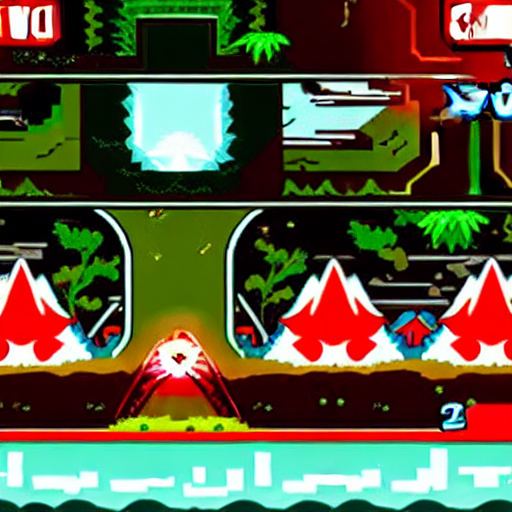

In [9]:
with torch.no_grad():
    image = pipe(
        prompt=positive_prompt, negative_prompt=negative_prompt, num_inference_steps=20, guidance_scale=cfg_strength
    )
image.images[0]

# our pipeline

In [2]:
sys.path.append(os.path.abspath('../kcg-ml-image-pipeline/'))

from utility.minio.cmd import connect_to_minio_client
from worker.image_generation.scripts.stable_diffusion_base_script import StableDiffusionBaseScript
from stable_diffusion import CLIPTextEmbedder

In [3]:
model_path = '../kcg-ml-image-pipeline/input/model/sd/v1-5-pruned-emaonly/v1-5-pruned-emaonly.safetensors'
tokenizer_path = '../kcg-ml-image-pipeline/input/model/clip/txt_emb_tokenizer'
transformer_path = '../kcg-ml-image-pipeline/input/model/clip/txt_emb_model'

In [4]:
txt2img = StableDiffusionBaseScript(
    sampler_name="ddim",
    n_steps=20,
    force_cpu=False,
    cuda_device='cuda',
)

In [5]:
txt2img.initialize_latent_diffusion(
    autoencoder=None, 
    clip_text_embedder=None, 
    unet_model=None,
    path=model_path, 
    force_submodels_init=True)

  encoder initialization...[DONE]	1,903.05ms                                      
  decoder initialization...[DONE]	543.94ms                                        
Autoencoder initialization...[DONE]	2,461.03ms                                    
U-Net initialization...[DONE]	6,660.41ms                                          
Latent Diffusion model initialization...[DONE]	28.19ms                            
stable diffusion checkpoint loading, from ../kcg-ml-image-pipeline/input/model/sd/v1-5-pruned-emaonly/v1-5-pruned-emaonly.safetensors...[DONE]	529.84ms
	missing keys 2: ['beta', 'alpha_bar']
	extra keys 14: ['alphas_cumprod', 'alphas_cumprod_prev', 'betas', 'log_one_minus_alphas_cumprod', 'model_ema.decay', 'model_ema.num_updates', 'posterior_log_variance_clipped', 'posterior_mean_coef1', 'posterior_mean_coef2', 'posterior_variance', 'sqrt_alphas_cumprod', 'sqrt_one_minus_alphas_cumprod', 'sqrt_recip_alphas_cumprod', 'sqrt_recipm1_alphas_cumprod']
model state loading...[DONE]	5,

In [6]:
clip_text_embedder = CLIPTextEmbedder(device='cuda')

In [7]:
clip_text_embedder.load_submodels(
    tokenizer_path=tokenizer_path,
    transformer_path=transformer_path
);

Loading tokenizer and transformer...[DONE]	1,562.50ms                             


In [8]:
def get_image_data(images: torch.Tensor):
    # Map images to `[0, 1]` space and clip
    images = torch.clamp((images + 1.0) / 2.0, min=0.0, max=1.0)
    # Transpose to `[batch_size, height, width, channels]` and convert to numpy
    images = images.cpu()
    images = images.permute(0, 2, 3, 1)
    images = images.detach().float().numpy()

    return Image.fromarray((255. * images[0]).astype(np.uint8))

# generate

In [123]:
with torch.no_grad():
    
    embedded_prompts = clip_text_embedder(positive_prompt)
    negative_embedded_prompts = clip_text_embedder(negative_prompt)
    
    latent = txt2img.generate_images_latent_from_embeddings(
        batch_size=1,
        embedded_prompt=embedded_prompts,
        null_prompt=negative_embedded_prompts,
        uncond_scale=cfg_strength,
        seed=seed,
        w=image_width,
        h=image_height
    )
    
    images = txt2img.get_image_from_latent(latent)

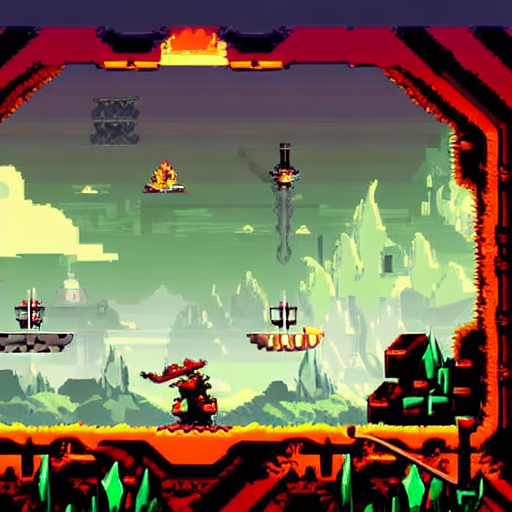

In [124]:
get_image_data(images)

# replicate

In [9]:
from minio import Minio
import requests
import msgpack

In [13]:
MINIO_ADDRESS = "123.176.98.90:9000"
access_key = "GXvqLWtthELCaROPITOG"
secret_key = "DmlKgey5u0DnMHP30Vg7rkLT0NNbNIGaM8IwPckD"

In [17]:
bucket_name = 'datasets'
object_name = 'environmental/0394/393026_data.msgpack'

In [15]:
client = connect_to_minio_client(MINIO_ADDRESS, access_key, secret_key)

Connecting to minio client...
Successfully connected to minio client...


In [18]:
data = client.get_object(bucket_name, object_name).data
decoded_data = msgpack.unpackb(data)
decoded_data

{'job_uuid': '6dc7c217-6014-487c-8199-efe9fa1ce695',
 'creation_time': '2024-01-08 12:21:02',
 'dataset': 'environmental',
 'file_path': 'environmental/0394/393026.jpg',
 'file_hash': 'af9a6141bcb8a275c2a2e1d06fc16c788763402deca246f2b5f5faa480855846',
 'positive_prompt': 'environmental art side scrolling, inside dark ancient roman building, space survival adventure, white background flat illustration, side scrolling, the atmosphere is palpable, portal opening, woman in power armorarmor, dreamy visual, at music festival, female elf in green clothes, beam of light shining in the center of the stage, fine art quality',
 'negative_prompt': 'curved line, hyper realistic image with cinematic quality, softedgehed, backlight, weird legs position, genitals bad anatomy. peoples faces deformed with defects like errors or flaws, kneeling on all fours, realistic photo detail shading text font letters, fingers or hands and feet on ground vehicle style vehicles outliney people, beauty spot',
 'cfg_st

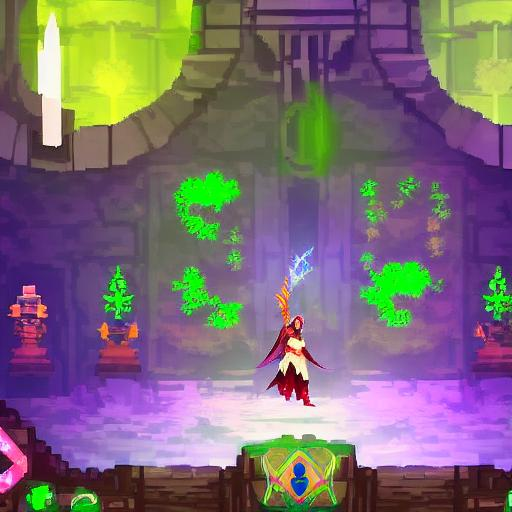

In [19]:
data = client.get_object(bucket_name, object_name.replace('_data.msgpack', '.jpg')).data
Image.open(BytesIO(data))

In [20]:
positive_prompt = decoded_data['positive_prompt']
negative_prompt = decoded_data['negative_prompt']
seed = decoded_data['seed']
cfg_strength = decoded_data['cfg_strength']
image_width = decoded_data['image_width']
image_height = decoded_data['image_height']

In [22]:
with torch.no_grad():
    
    embedded_prompts = clip_text_embedder(positive_prompt)
    # negative_embedded_prompts = clip_text_embedder(negative_prompt)
    negative_embedded_prompts = clip_text_embedder('')
    
    latent = txt2img.generate_images_latent_from_embeddings(
        batch_size=1,
        embedded_prompt=embedded_prompts,
        null_prompt=negative_embedded_prompts,
        uncond_scale=cfg_strength,
        seed=seed,
        w=image_width,
        h=image_height
    )
    
    images = txt2img.get_image_from_latent(latent)

Sample...[DONE]	6,773.63ms                                                        


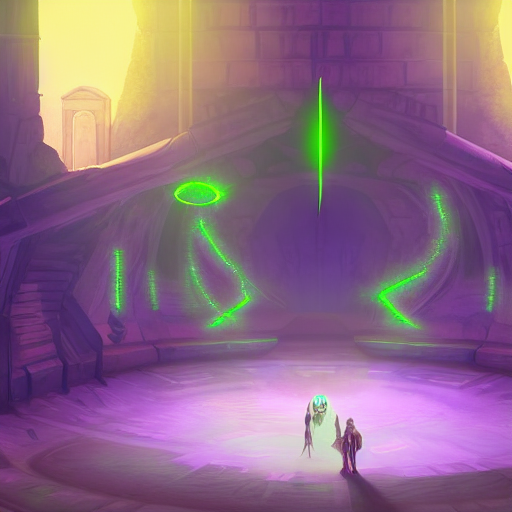

In [23]:
get_image_data(images)